In [1]:
import brian2.only as b2
from brian2 import np, mwatt, mV, mm, mm2, nmeter, cm, ufarad, Mohm, ms, Hz, msiemens, pA, nA, uA, volt, second, siemens ,Hz
import cleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib widget

# numpy faster than cython for lightweight example
b2.prefs.codegen.target = "numpy"
# long dt for faster sim
b2.defaultclock.dt = 0.5 * ms
# for reproducibility
b2.seed(2024)
cleo.utilities.set_seed(2024)

### Make a network of 15x9 grid squares with each square having around 20 neurons

In [2]:
width=1.5
height=0.9
depth=0.3
xmax_mm = width
density = 500
n = int(width * height * depth * density)

# colors
c = {
    "main": "#C500CC",
    "473nm": "#72b5f2",
    "590nm": (1, 0.875, 0),
}

ng = b2.NeuronGroup(
    n,
    """
    dv/dt = (
        -(v - E_L)
        + Delta_T*exp((v-theta)/Delta_T)
        + Rm*(I_exc + I_inh + I_bg + I_enphr)
    ) / tau_m + sigma*sqrt(2/tau_m)*xi: volt
    I_exc : amp
    I_inh : amp
    I_enphr : amp
    """,
    threshold="v > -10*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * b2.Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70 * mV,
        "sigma": 5 * mV,
        "I_bg": 20 * pA,
    },
)
ng.v = np.random.uniform(-70, -60, n) * mV

W = 1 * mV
p_S = 0.3
n_neighbors = 25
S_ee = b2.Synapses(ng, model="w: 1", on_pre="v_post+=W*w/sqrt(N)")
S_ee.connect(condition="abs(i-j)<=n_neighbors and i!=j")
S_ee.w = np.exp(np.random.randn(int(S_ee.N - 0))) * np.random.choice(
    [-1, 1], int(S_ee.N - 0)
)

spike_mon = b2.SpikeMonitor(ng)
# for visualizing currents
Imon = b2.StateMonitor(ng, ("I_exc", "I_inh", "I_enphr"), record=range(20))
net = b2.Network(ng, S_ee, spike_mon, Imon)
sim = cleo.CLSimulator(net)

tissue_depth_mm = 0.3
# cleo.coords.assign_coords_grid_rect_prism(ng, xlim=(0, w), ylim=(0,h), zlim=(0, tissue_depth_mm), shape=(15,9,3))
cell_locs = cleo.coords.assign_coords_rand_rect_prism(ng, xlim=(0, width), ylim=(0,height), zlim=(0, depth), )

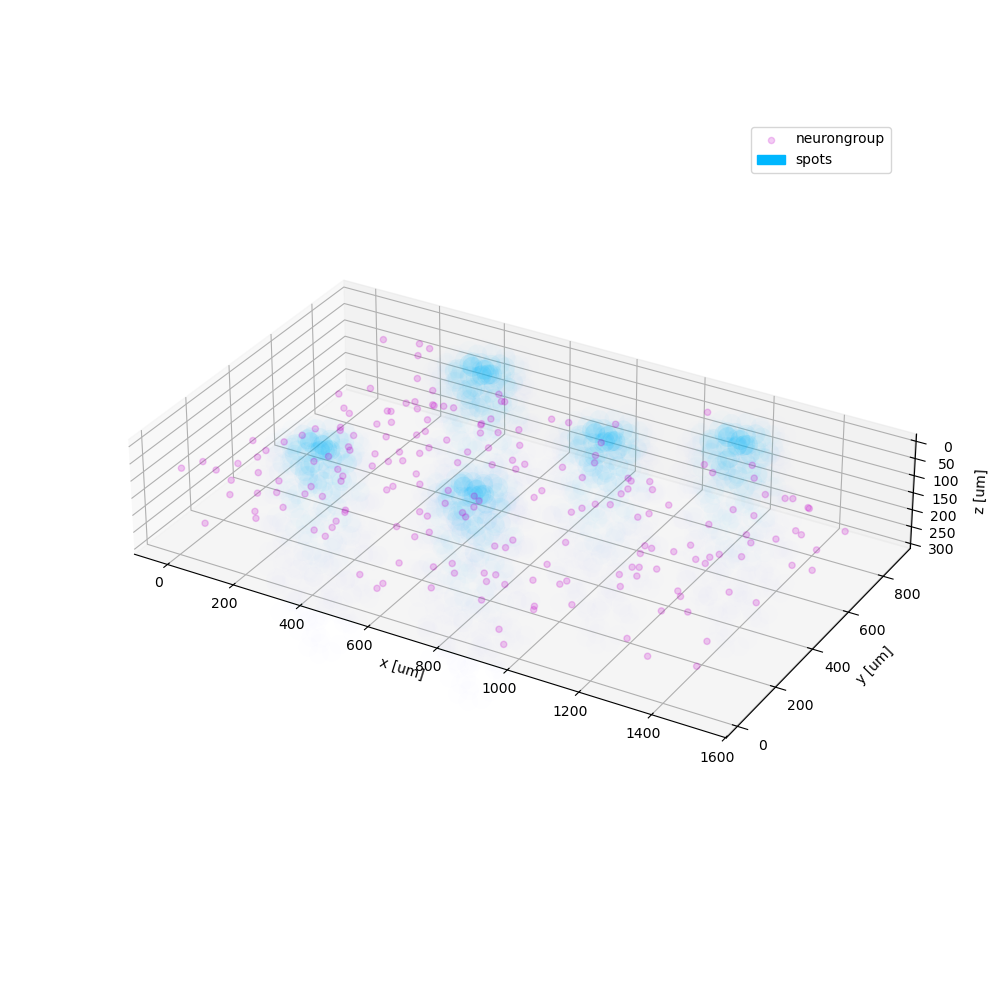

In [3]:
n_spots = 5
stim_coords = np.array([
                    [0.30,0.20,0.0],
                    [0.45,0.75,0.0],
                    [0.75,0.20,0.0],
                    [0.90,0.60,0.0],
                    [1.20,0.75,0.0]
                ])
end_space = 1 / (2 * n_spots)

spots = cleo.light.Light(
    coords=stim_coords * mm,
    name = 'spots',
    light_model=cleo.light.fiber473nm(),
    wavelength=473*b2.nmeter,
)
sim.inject(spots, ng)
chr2 = cleo.opto.chr2_4s()
sim.inject(chr2, ng, Iopto_var_name="I_exc")

fig,ax = cleo.viz.plot(ng, colors=[c["main"]], sim=sim)
# increase the size and save the fig
fig.set_size_inches(10, 10)
fig.savefig("optical_transfer_function_5sq_recur25.png")
fig.savefig("optical_transfer_function_5sq_recur25.svg")

In [4]:
from cleo.ioproc import LatencyIOProcessor
# https://cleosim.readthedocs.io/latest/tutorials/multi_opto.html#injecting-a-multi-channel-light


class OpenLoopOpto(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period=1 * ms)

    # since this is open-loop, we don't use state_dict
    def process(self, state_dict, t_samp):
        amplitude = 0.5 * mwatt / mm2
        time_offsets = np.array([0, -50,-100,-150,-200]) 
        t = t_samp / ms + time_offsets
        blue = (((t >= 100) & (t < 120)) | ((t >= 300) & (t < 320))) * amplitude
        # return output dict and time
        return ({"spots": blue}, t_samp)


sim.set_io_processor(OpenLoopOpto())

CLSimulator(io_processor=OpenLoopOpto(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={Light(name='spots', save_history=True, value=array([0., 0., 0., 0., 0.]), light_model=OpticFiber(R0=100. * umetre, NAfib=0.37, K=125. * metre ** -1, S=7370. * metre ** -1, ntis=1.36), wavelength=0.473 * umetre, direction=array([0., 0., 1.]), max_value=None, max_value_viz=None), FourStateOpsin(name='ChR2', save_history=True, on_pre='', spectrum=[(400, 0.34), (422, 0.65), (460, 0.96), (470, 1), (473, 1), (500, 0.57), (520, 0.22), (540, 0.06), (560, 0.01), (800, 1.257478763901864e-06), (844, 2.404003519224151e-06), (920, 3.5505282745464387e-06), (940, 3.6984669526525404e-06), (946, 3.6984669526525404e-06), (1000, 2.1081261630119477e-06), (1040, 8.136627295835588e-07), (1080, 2.2190801715915242e-07), (1120, 3.69846695265254e-08)], extrapolate=False, required_vars=[('Iopto', amp), ('v', volt)], g0=114. * nsiemens, gamma=0.00742, phim=2.33e+23 * (second ** -1) / (meter ** 2), 

In [5]:
sim.reset()
sim.run(1000 * ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.12s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_ChR2_neurongroup', using method 'euler' (took 0.03s, trying other methods took 0.12s). [brian2.stateupdaters.base.method_choice]


In [6]:
cellid = spike_mon.i
spike_times = spike_mon.t

cell_locs_x = ng.x
cell_locs_y = ng.y
cell_locs_z = ng.z

In [7]:
cells = pd.DataFrame({'cellid':range(len(cell_locs_x)),
                        'cell_locs_x':1000*np.array(cell_locs_x),
                        'cell_locs_y':1000*np.array(cell_locs_y),
                        'cell_locs_z':1000*np.array(cell_locs_z)
                        },)
spikes = pd.DataFrame({'cellid':np.array(cellid),
                        'spike_times':np.array(spike_times),
                        },)

In [8]:
spikes['cell_locs_x'] = [cells['cell_locs_x'][i] for i in spikes['cellid']]
spikes['cell_locs_y'] = [cells['cell_locs_y'][i] for i in spikes['cellid']]
spikes['cell_locs_z'] = [cells['cell_locs_z'][i] for i in spikes['cellid']]

In [9]:
def calculate_cell_stim_distance(cell_loc, stim_loc):
    dist2d =  np.sqrt((cell_loc[0] - stim_loc[0])**2 + (cell_loc[1] - stim_loc[1])**2)
    dist3d =  np.sqrt((cell_loc[0] - stim_loc[0])**2 + (cell_loc[1] - stim_loc[1])**2 + (cell_loc[2] - stim_loc[2])**2)
    return dist2d

In [10]:
def select_stim(cell_locs):
    dists = [calculate_cell_stim_distance(cell_locs, stim_loc) for stim_loc in stim_coords]
    return np.argmin(dists, axis=0)

In [11]:
spikes['spot'] = [select_stim(cell_locs) for cell_locs in spikes[['cell_locs_x','cell_locs_y','cell_locs_z']].values]

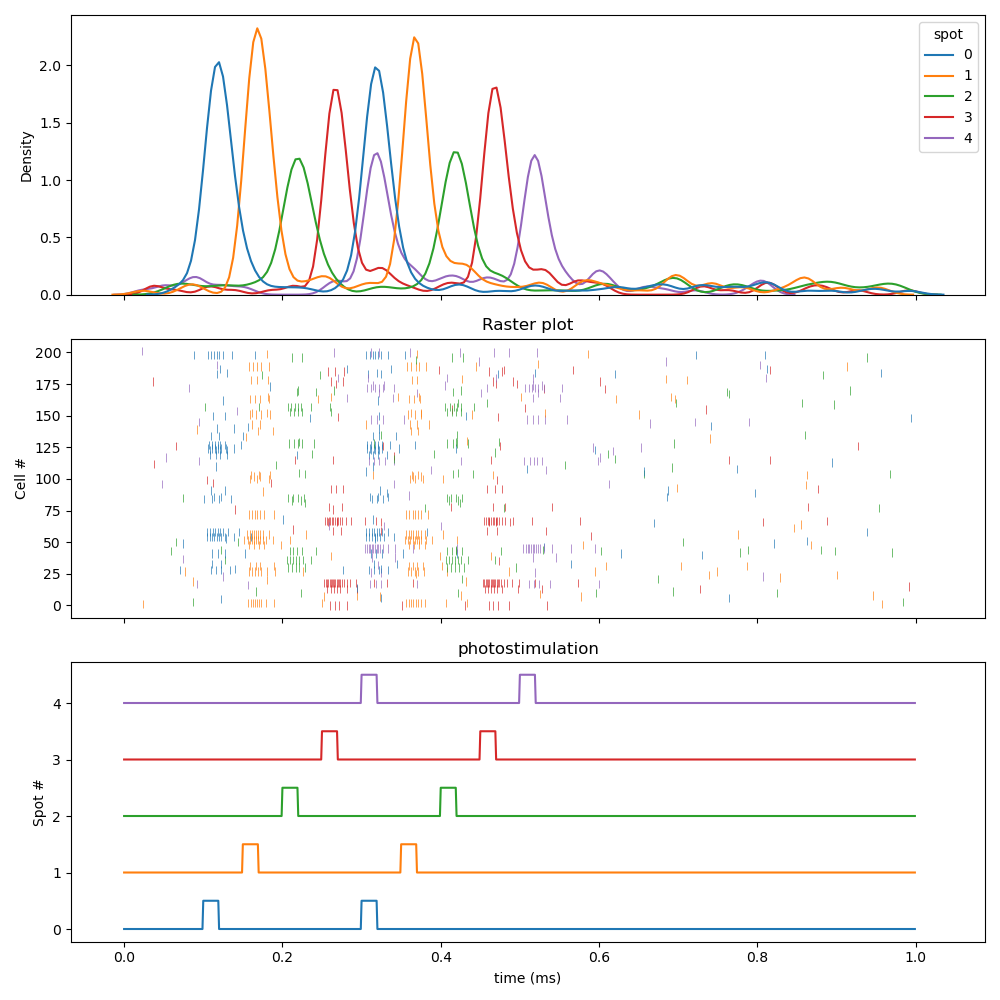

In [12]:
fig,ax = plt.subplots(3,1, sharex=True)

sns.kdeplot(ax=ax[0], data=spikes, x="spike_times", hue="spot", palette="tab10", bw_adjust=.2)

sns.scatterplot(data=spikes, x='spike_times', y='cellid', hue='spot', palette='tab10', marker='|', ax=ax[1])
ax[1].legend([], frameon=False)
ax[1].set(ylabel='Cell #', title='Raster plot',)

ax[2].plot(spots.t, spots.irradiance_ + np.arange(n_spots),)
ax[2].set(ylabel="Spot #",title="photostimulation", xlabel="time (ms)",)

# save figs
fig.set_size_inches(10, 10)
fig.tight_layout()
fig.savefig("optical_transfer_function_5spots_raster_recur25.png")
fig.savefig("optical_transfer_function_5spots_raster_recur25.svg")

## Changing recurrence

In [13]:
width=1.5
height=0.9
depth=0.3
xmax_mm = width
density = 500
n = int(width * height * depth * density)

# colors
c = {
    "main": "#C500CC",
    "473nm": "#72b5f2",
    "590nm": (1, 0.875, 0),
}

ng = b2.NeuronGroup(
    n,
    """
    dv/dt = (
        -(v - E_L)
        + Delta_T*exp((v-theta)/Delta_T)
        + Rm*(I_exc + I_inh + I_bg + I_enphr)
    ) / tau_m + sigma*sqrt(2/tau_m)*xi: volt
    I_exc : amp
    I_inh : amp
    I_enphr : amp
    """,
    threshold="v > -10*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * b2.Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70 * mV,
        "sigma": 5 * mV,
        "I_bg": 20 * pA,
    },
)
ng.v = np.random.uniform(-70, -60, n) * mV

W = 1 * mV
p_S = 0.3
n_neighbors = 100
S_ee = b2.Synapses(ng, model="w: 1", on_pre="v_post+=W*w/sqrt(N)")
S_ee.connect(condition="abs(i-j)<=n_neighbors and i!=j")
S_ee.w = np.exp(np.random.randn(int(S_ee.N - 0))) * np.random.choice(
    [-1, 1], int(S_ee.N - 0)
)

spike_mon = b2.SpikeMonitor(ng)
# for visualizing currents
Imon = b2.StateMonitor(ng, ("I_exc", "I_inh", "I_enphr"), record=range(20))
net = b2.Network(ng, S_ee, spike_mon, Imon)
sim = cleo.CLSimulator(net)

tissue_depth_mm = 0.3
# cleo.coords.assign_coords_grid_rect_prism(ng, xlim=(0, w), ylim=(0,h), zlim=(0, tissue_depth_mm), shape=(15,9,3))
cell_locs = cleo.coords.assign_coords_rand_rect_prism(ng, xlim=(0, width), ylim=(0,height), zlim=(0, depth), )

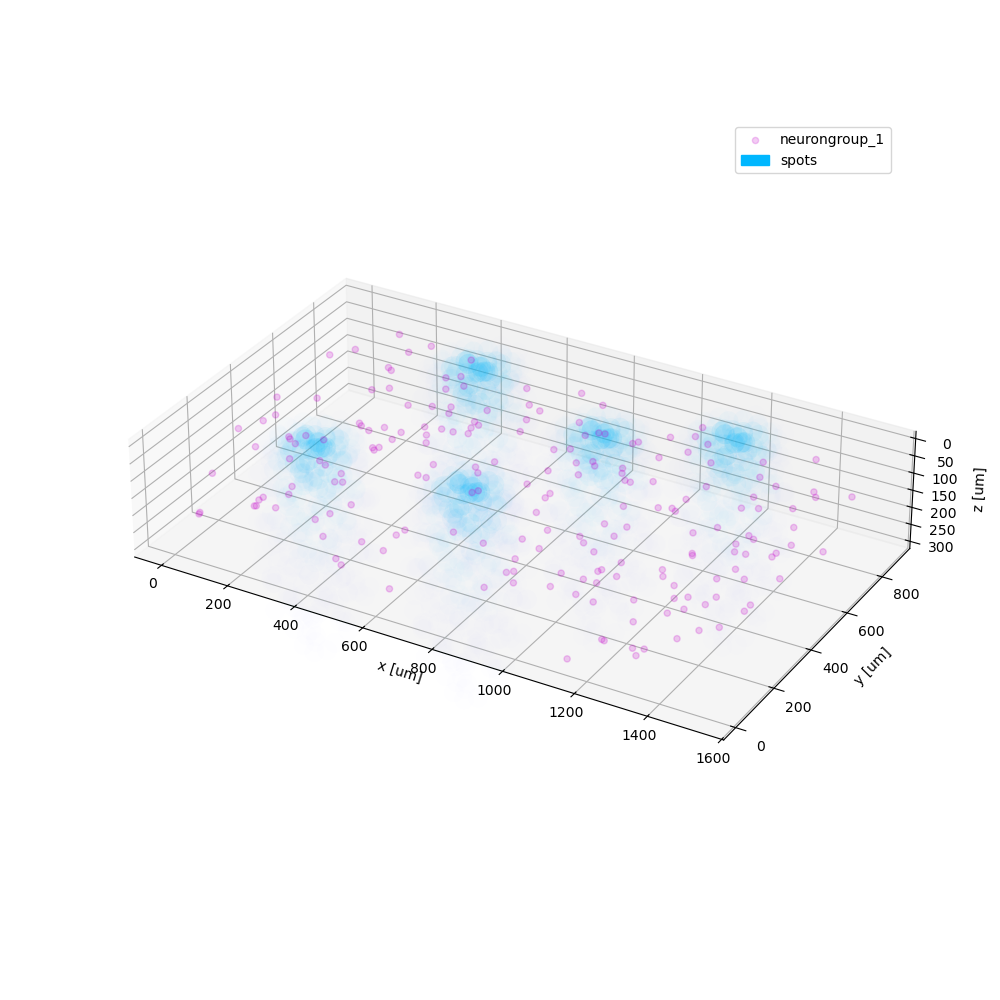

In [14]:
n_spots = 5
stim_coords = np.array([
                    [0.30,0.20,0.0],
                    [0.45,0.75,0.0],
                    [0.75,0.20,0.0],
                    [0.90,0.60,0.0],
                    [1.20,0.75,0.0]
                ])
end_space = 1 / (2 * n_spots)

spots = cleo.light.Light(
    coords=stim_coords * mm,
    name = 'spots',
    light_model=cleo.light.fiber473nm(),
    wavelength=473*b2.nmeter,
)
sim.inject(spots, ng)
chr2 = cleo.opto.chr2_4s()
sim.inject(chr2, ng, Iopto_var_name="I_exc")

fig,ax = cleo.viz.plot(ng, colors=[c["main"]], sim=sim)
# increase the size and save the fig
fig.set_size_inches(10, 10)
fig.savefig("optical_transfer_function_5sq_recur100.png")
fig.savefig("optical_transfer_function_5sq_recur100.svg")

In [15]:
from cleo.ioproc import LatencyIOProcessor
# https://cleosim.readthedocs.io/latest/tutorials/multi_opto.html#injecting-a-multi-channel-light


class OpenLoopOpto(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period=1 * ms)

    # since this is open-loop, we don't use state_dict
    def process(self, state_dict, t_samp):
        amplitude = 0.5 * mwatt / mm2
        time_offsets = np.array([0, -50,-100,-150,-200]) 
        t = t_samp / ms + time_offsets
        blue = (((t >= 100) & (t < 120)) | ((t >= 300) & (t < 320))) * amplitude
        # return output dict and time
        return ({"spots": blue}, t_samp)


sim.set_io_processor(OpenLoopOpto())

CLSimulator(io_processor=OpenLoopOpto(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={FourStateOpsin(name='ChR2', save_history=True, on_pre='', spectrum=[(400, 0.34), (422, 0.65), (460, 0.96), (470, 1), (473, 1), (500, 0.57), (520, 0.22), (540, 0.06), (560, 0.01), (800, 1.257478763901864e-06), (844, 2.404003519224151e-06), (920, 3.5505282745464387e-06), (940, 3.6984669526525404e-06), (946, 3.6984669526525404e-06), (1000, 2.1081261630119477e-06), (1040, 8.136627295835588e-07), (1080, 2.2190801715915242e-07), (1120, 3.69846695265254e-08)], extrapolate=False, required_vars=[('Iopto', amp), ('v', volt)], g0=114. * nsiemens, gamma=0.00742, phim=2.33e+23 * (second ** -1) / (meter ** 2), k1=4.15 * khertz, k2=0.868 * khertz, p=0.833, Gf0=37.3 * hertz, kf=58.1 * hertz, Gb0=16.1 * hertz, kb=63. * hertz, q=1.94, Gd1=105. * hertz, Gd2=13.8 * hertz, Gr0=0.33 * hertz, E=0. * volt, v0=43. * mvolt, v1=17.1 * mvolt, model='\n        dC1/dt = Gd1*O1 + Gr0*C2 - Ga1*C1 : 1 (

In [16]:
sim.reset()
sim.run(1000 * ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_ChR2_neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]


In [17]:
cellid = spike_mon.i
spike_times = spike_mon.t

cell_locs_x = ng.x
cell_locs_y = ng.y
cell_locs_z = ng.z

In [18]:
cells = pd.DataFrame({'cellid':range(len(cell_locs_x)),
                        'cell_locs_x':1000*np.array(cell_locs_x),
                        'cell_locs_y':1000*np.array(cell_locs_y),
                        'cell_locs_z':1000*np.array(cell_locs_z)
                        },)
spikes = pd.DataFrame({'cellid':np.array(cellid),
                        'spike_times':np.array(spike_times),
                        },)

In [19]:
spikes['cell_locs_x'] = [cells['cell_locs_x'][i] for i in spikes['cellid']]
spikes['cell_locs_y'] = [cells['cell_locs_y'][i] for i in spikes['cellid']]
spikes['cell_locs_z'] = [cells['cell_locs_z'][i] for i in spikes['cellid']]

In [20]:
spikes['spot'] = [select_stim(cell_locs) for cell_locs in spikes[['cell_locs_x','cell_locs_y','cell_locs_z']].values]

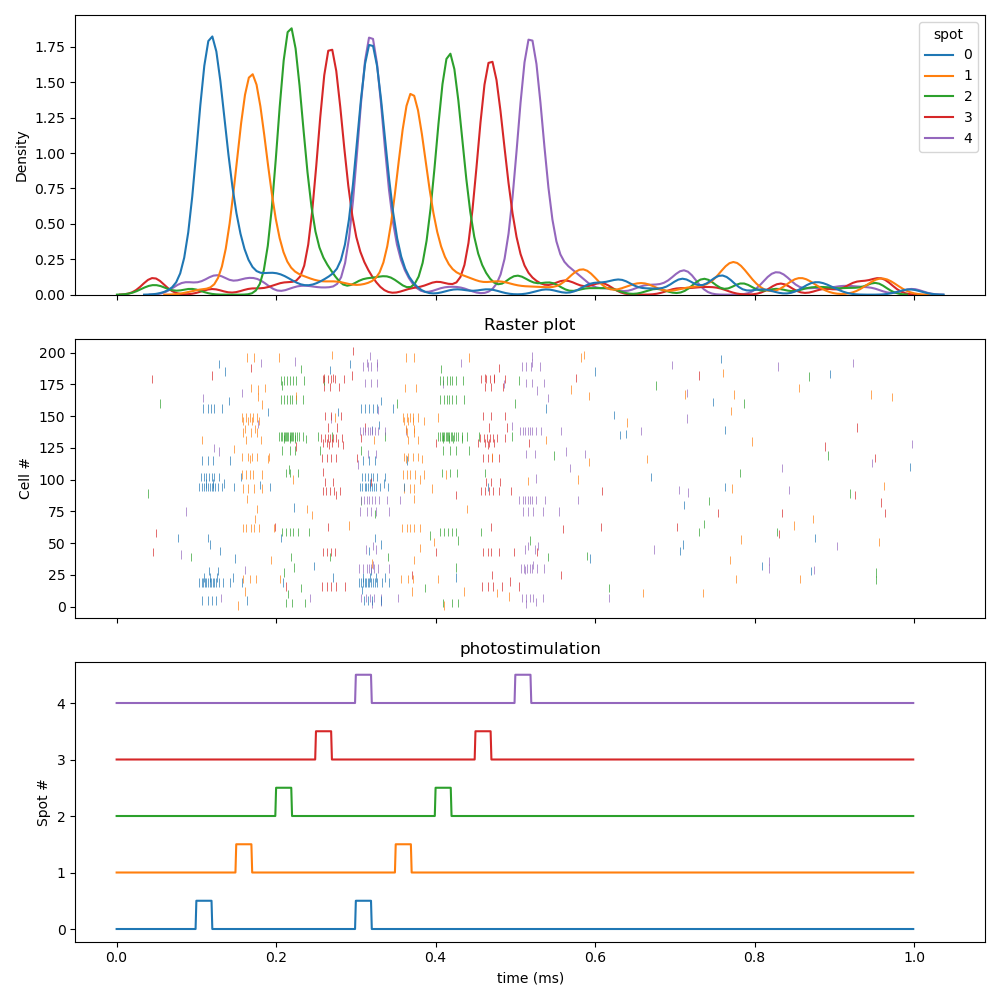

In [21]:
fig,ax = plt.subplots(3,1, sharex=True)

sns.kdeplot(ax=ax[0], data=spikes, x="spike_times", hue="spot", palette="tab10", bw_adjust=.2)

sns.scatterplot(data=spikes, x='spike_times', y='cellid', hue='spot', palette='tab10', marker='|', ax=ax[1])
ax[1].legend([], frameon=False)
ax[1].set(ylabel='Cell #', title='Raster plot',)

ax[2].plot(spots.t, spots.irradiance_ + np.arange(n_spots),)
ax[2].set(ylabel="Spot #",title="photostimulation", xlabel="time (ms)",)

# save figs
fig.set_size_inches(10, 10)
fig.tight_layout()
fig.savefig("optical_transfer_function_5spots_raster_recur100.png")
fig.savefig("optical_transfer_function_5spots_raster_recur100.svg")

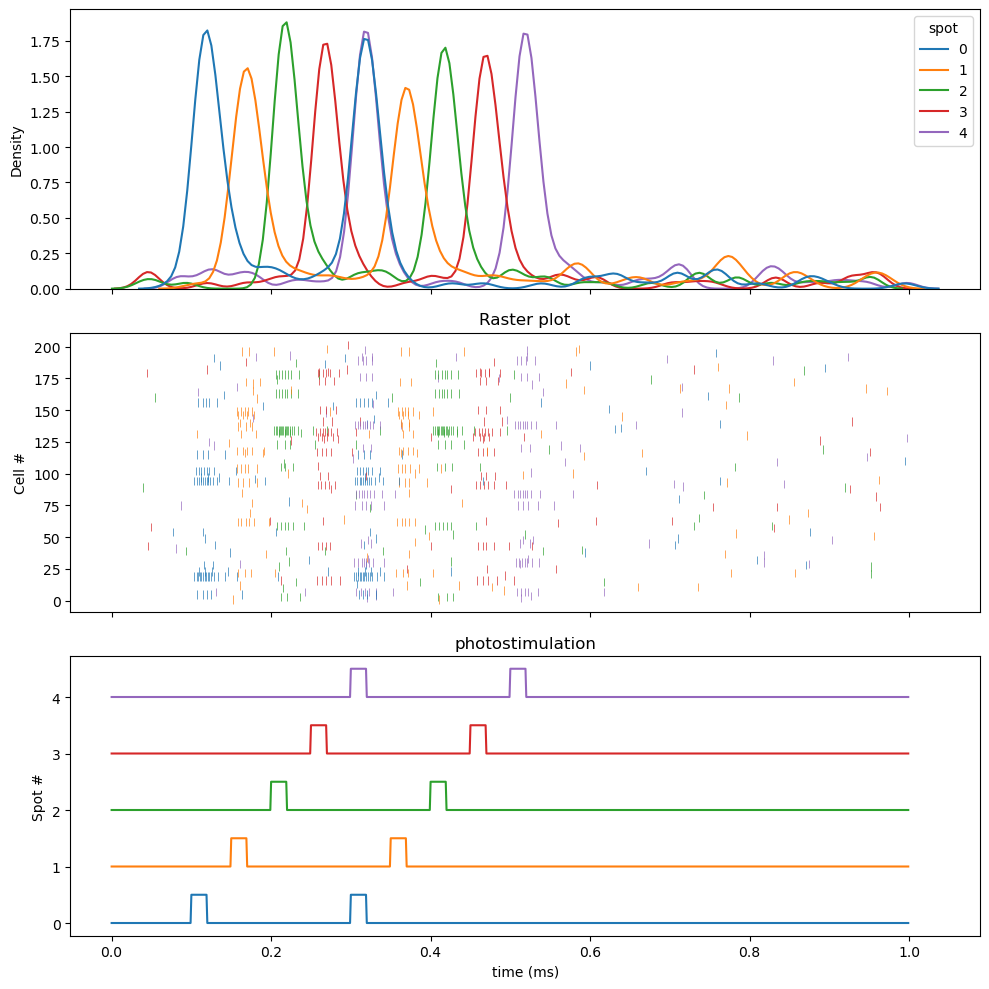

In [22]:
fig

### distance vs activity

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from cleo import ephys
from cleo.coords import assign_coords_rand_rect_prism

n = 100
ng = b2.NeuronGroup(
    n,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + Rm*I) / tau_m : volt
    I : amp
    """,
    threshold="v>30*mV",
    reset="v=-55*mV",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70 * mV,
    },
)
ng.v = -70 * mV

input_group = b2.PoissonInput(ng, "v", 1, 100 * Hz, 10 * mV)

mon = b2.SpikeMonitor(ng)

net = b2.Network(ng, input_group, mon)
ng.equations


assign_coords_rand_rect_prism(ng, xlim=(-0.1, 0.1), ylim=(-0.1, 0.1), zlim=(0.3, 0.6))

opsin = cleo.opto.chr2_4s()
fiber = cleo.light.Light(
    coords=(0, 0, 0) * mm,
    light_model=cleo.light.fiber473nm(),
    name="fiber",
    wavelength=473 * nmeter,
)
sim = cleo.CLSimulator(net)

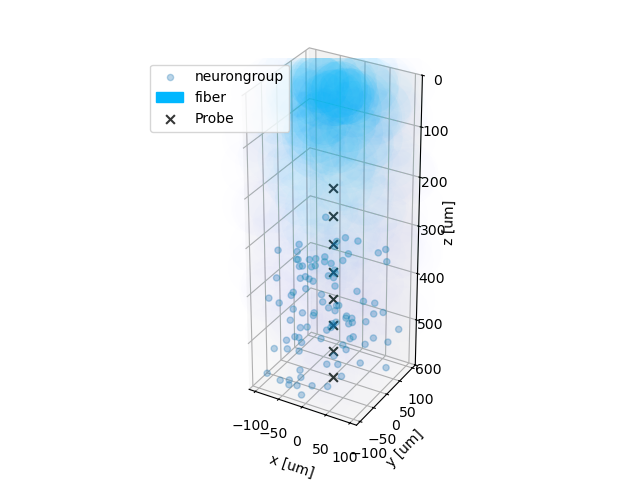

In [3]:
coords = ephys.linear_shank_coords(0.4 * b2.mm, 8, start_location=(0, 0, 0.2) * b2.mm)
probe = ephys.Probe(coords, save_history=True)
cleo.viz.plot(
    ng,
    zlim=(0, 600),
    devices=[fiber,probe],
    scatterargs={"alpha": 0.3},
);


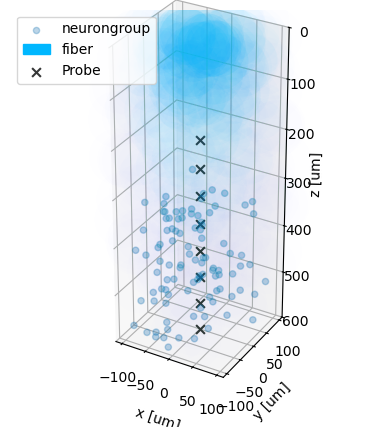

In [4]:
plt.gcf()

In [5]:
mua = ephys.MultiUnitSpiking(
    r_perfect_detection=0.05 * b2.mm,
    r_half_detection=0.1 * b2.mm,
)
ss = ephys.SortedSpiking(0.05 * b2.mm, 0.1 * b2.mm)
tklfp = ephys.TKLFPSignal()
rwslfp = ephys.RWSLFPSignalFromSpikes()

probe.add_signals(mua, ss, tklfp, rwslfp)

sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period=1 * b2.ms))

CLSimulator(io_processor=RecordOnlyProcessor(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices=set())

In [6]:

sim.inject(opsin, ng, Iopto_var_name="I")
sim.inject(fiber, ng)
sim.inject(probe, ng, tklfp_type="exc",)

def stimulus(t):
    f = 25 * Hz
    unrectified = 2 * np.sin(2 * np.pi * f * t)
    rectified = unrectified * (unrectified > 0)
    return rectified


class OpenLoopOpto(cleo.ioproc.LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period=1 * b2.ms)

    # since this is open-loop, we don't use state_dict
    def process(self, state_dict, t):
        opto_intensity = stimulus(t)
        # return output dict and time
        return ({"fiber": opto_intensity * mwatt / mm2}, t)




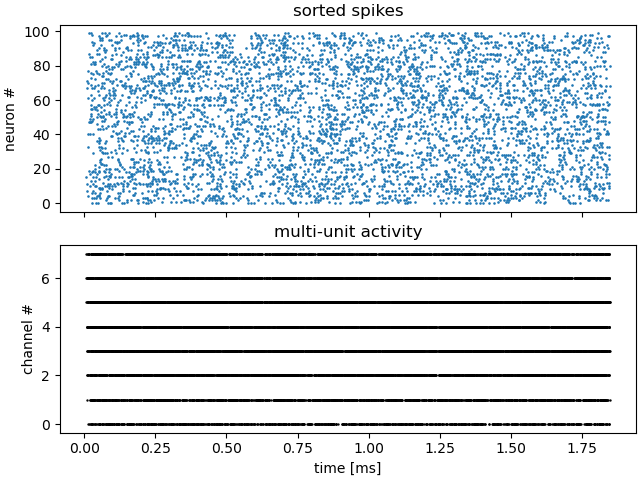

In [19]:
sim.run(250 * b2.ms)

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

fig, axs = plt.subplots(2, 1, sharex=True, layout="constrained")

# assuming all neurons are detectable for c=ss.i >= n_e to work
# in practice this will often not be the case and we'd have to map
# from probe index to neuron group index using ss.i_probe_by_i_ng.inverse
axs[0].scatter(
    ss.t, ss.i, marker=".", s=3, rasterized=True)
axs[0].set(title="sorted spikes", ylabel="neuron #")

axs[1].scatter(mua.t, mua.i, marker=".", s=2, c="black", rasterized=True)
axs[1].set(title="multi-unit activity", ylabel="channel #", xlabel="time [ms]")
fig.savefig("spikes.svg")


# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# ax1.plot(mon.t / ms, mon.i, "|")
# ax1.set(ylabel="neuron index", title="spiking")
# ax2.plot(fiber.t / ms, fiber.irradiance_)
# ax2.set(
#     ylabel=r"$Irr_0$ (mm/mW$^2$)", title="optogenetic stimulus", xlabel="time [ms]"
# )

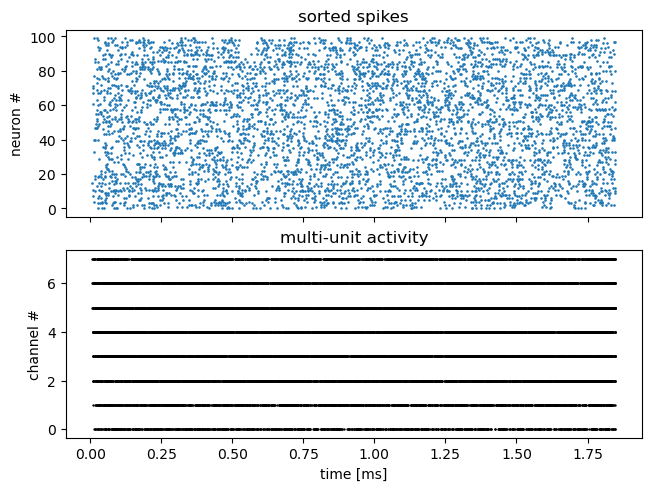

In [20]:
fig

In [94]:
spikes = pd.DataFrame({"neuron": list(mon.i), "time": list(mon.t / ms)})
spikes = spikes.pivot(index="neuron", columns="time", values="time")
# replace nan with 0 and convert to boolean
spikes = spikes.notnull().astype(int)
spikes


time,6.0,7.0,8.0,8.5,9.0,10.0,10.5,11.0,11.5,12.0,...,95.0,95.5,96.0,96.5,97.0,97.5,98.0,98.5,99.0,99.5
neuron,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [95]:
irr = np.array(fiber.irradiance_).reshape(-1)
stim = pd.DataFrame({"light": (irr)/np.max(irr), "time": list(fiber.t / ms)})

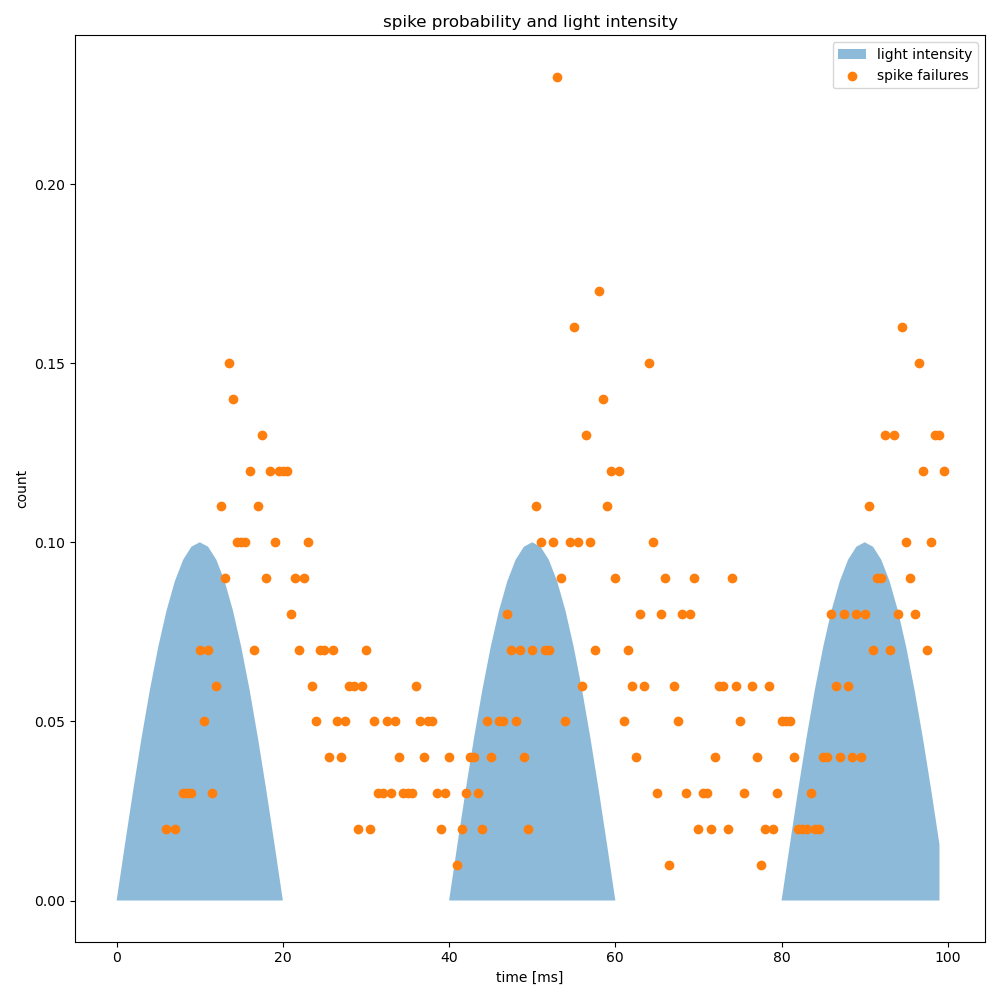

In [100]:
# plot spike failures: count how many spikes in every time bin
spike_fraction = spikes.sum(axis=0) / n

fig, ax = plt.subplots()
ax.fill_between(stim.time, 0.1*stim.light, label="light intensity", alpha=0.5)
ax.scatter(spike_fraction.index, spike_fraction, label="spike failures")
ax.legend()
ax.set(xlabel="time [ms]", ylabel="count", title="spike probability and light intensity")

# save figs
fig.set_size_inches(10, 10)
fig.tight_layout()
fig.savefig("optical_transfer_function_25Hz_spikefailure.png")

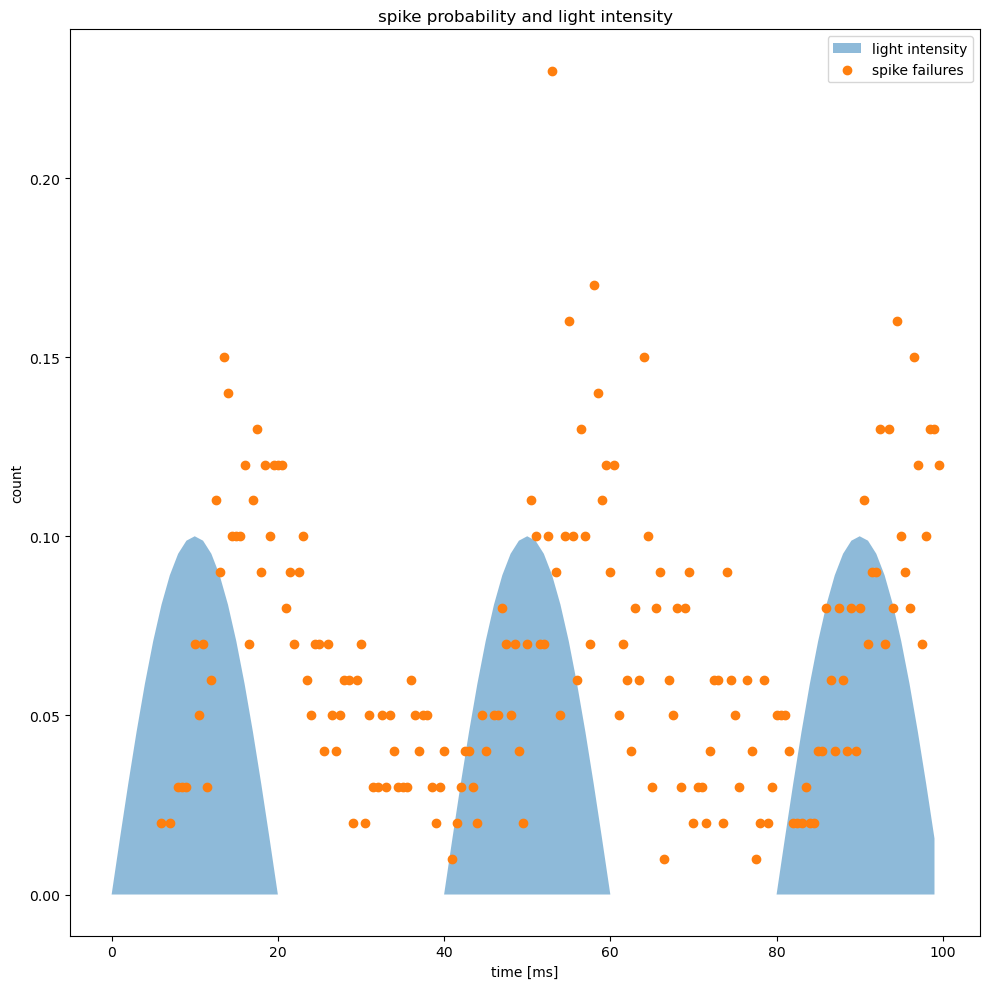

In [101]:
fig